# Benchmarking of Forecasting Models

This notebook guides you through the end-to-end process of forecasting. We start with data ingestion and transformation before diving into feature engineering. Next, the workflow trains several forecasting models—including XGBoost, Naive, and SARIMA—and evaluates them using a sliding window backtesting strategy. Finally, the performance of these models is visualized, and all experiments along with their parameters, metrics, and artifacts are logged via MLflow.

# Imports and Setup

In [ ]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import importlib
import mlflow
from typing import Tuple

from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils, config, mlflow_utils, training

importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)
importlib.reload(config)
importlib.reload(mlflow_utils)
importlib.reload(training)

from mlflow.exceptions import MlflowException
from loguru import logger


from xgboost import XGBRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sktime.transformations.series.difference import Differencer



from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

import mlflow
from mlflow.exceptions import MlflowException
from mlflow.tracking import MlflowClient
from loguru import logger
from pathlib import Path
from urllib.parse import quote

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sktime')

2025-07-20 23:38:40.948 | INFO     | oceanwave_forecast.config:<module>:11 - PROJ_ROOT path is: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast


# MLflow Experiment Tracking

In this notebook, we leverage MLflow to track and log our forecasting experiments. By setting the MLflow tracking URI to our local directory, we can:
- Easily register and organize multiple experiment runs.
- Fetch detailed information (parameters, metrics, artifacts) for every run.
- Compare model performances effectively.

The subsequent code cell demonstrates how to retrieve and display these runs, enabling us to analyze our forecasting pipeline outcomes systematically.

In [55]:
# CHecking the experiment and its runs:

def fetch_and_log_runs_structured(experiment_name: str):
    """Fetch and display MLflow runs organized by run_number, using PROJ_ROOT/mlruns."""
    # ——— 1. ensure tracking URI is set to PROJ_ROOT/mlruns ———
    mlruns_path = config.PROJ_ROOT / "mlruns"
    mlruns_path.mkdir(parents=True, exist_ok=True)
    # URL‑encode to handle spaces, windows paths, etc.
    uri = f"file:///{quote(str(mlruns_path.absolute()), safe=':/')}"
    mlflow.set_tracking_uri(uri)
    logger.info(f"MLflow tracking URI set to: {uri}")

    try:
        # ——— 2. locate experiment by name ———
        client = MlflowClient()
        exp = client.get_experiment_by_name(experiment_name)
        if exp is None:
            logger.error(f"Experiment '{experiment_name}' not found at {mlruns_path}.")
            return

        # ——— 3. pull runs as DataFrame ———
        runs_df = mlflow.search_runs(
            experiment_ids=[exp.experiment_id],
            order_by=["attributes.start_time DESC"],
            output_format="pandas",
        )
        if runs_df.empty:
            logger.warning(f"No runs found for experiment '{experiment_name}'.")
            return

        # ——— 4. assemble detailed run info ———
        runs_data = []
        for rid in runs_df["run_id"]:
            run = client.get_run(rid)
            runs_data.append({
                "run_id": rid,
                "params": run.data.params,
                "metrics": run.data.metrics,
            })
        # sort by the integer run_number param
        runs_data.sort(key=lambda x: int(x["params"]["run_number"]))

        # ——— 5. pretty‑print ———
        print("=" * 60)
        print("MLFLOW EXPERIMENT RUNS")
        print("=" * 60)
        for run_data in runs_data:
            params = run_data["params"]
            metrics = run_data["metrics"]
            run_number = params["run_number"]
            model_name = params.get("model_type", params.get("model_name", "Unknown"))

            print(f"\n🔹 RUN {run_number} - {model_name}")
            print("-" * 40)
            print("📋 PARAMETERS:")
            for k, v in params.items():
                if k not in {"run_number", "model_type", "model_name"}:
                    print(f"  • {k}: {v}")
            print("📊 METRICS:")
            if metrics:
                for mk, mv in metrics.items():
                    print(f"  • {mk}: {mv:.6f}")
            else:
                print("  • No metrics recorded")
            print()

    except MlflowException as e:
        logger.exception(f"MLflow error: {e}")
    except Exception as e:
        logger.exception(f"Unexpected error: {e}")

fetch_and_log_runs_structured(config.MLFLOW_CONFIG_BACKTESTING['experiment_name'])

2025-07-20 23:12:18.161 | INFO     | __main__:fetch_and_log_runs_structured:11 - MLflow tracking URI set to: file:///D:%5CCML%5CTerm%208%5CML%20projects%5Cforecasting_workspace%5Coceanwave_forecast%5Cmlruns


MLFLOW EXPERIMENT RUNS

🔹 RUN 0 - NaiveForecaster
----------------------------------------
📋 PARAMETERS:
  • forecaster_params: {'forecasters': [('naive_last_WVHT', NaiveForecaster(), [0]), ('naive_mean_APD', NaiveForecaster(strategy='mean'), [1])], 'naive_last_WVHT': NaiveForecaster(), 'naive_mean_APD': NaiveForecaster(strategy='mean'), 'naive_last_WVHT__sp': 1, 'naive_last_WVHT__strategy': 'last', 'naive_last_WVHT__window_length': None, 'naive_mean_APD__sp': 1, 'naive_mean_APD__strategy': 'mean', 'naive_mean_APD__window_length': None}
📊 METRICS:
  • No metrics recorded


🔹 RUN 1 - XGBoost
----------------------------------------
📋 PARAMETERS:
  • colsample_bytree: 0.8
  • device: cuda
  • gamma: 0.0
  • learning_rate: 0.05
  • max_depth: 6
  • min_child_weight: 1.0
  • n_estimators: 800
  • n_jobs: -1
  • objective: reg:squarederror
  • random_state: 42
  • reg_alpha: 0.0
  • reg_lambda: 1.0
  • subsample: 0.8
  • targets: WVHT,APD
  • training_window: 504
  • tree_method: hist
📊 MET

# Data Preparation

In [ ]:
folder1_txt = config.RAW_DATA_DIR / 'Standard meteorological data 2024' / '46088h2024.txt'
data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
print("Raw data info:")
data_ocean_raw.info()

processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)
processed_data = processed_data.loc[config.START_DATE:config.END_DATE]

processed_data.info()

DataFrame shape: (52650, 13)

Info:


D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.241216     66.211796     80.537227  

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


### 2.1. Train-Test Split

In [ ]:
processed_data_Y = processed_data[config.TARGETS].copy()
processed_data_X = processed_data.drop(columns=config.TARGETS)


y_train, y_test, X_train, X_test = temporal_train_test_split(y=processed_data_Y, X=processed_data_X, test_size=config.HORIZON*3)

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

y_train shape: (4152, 2)
y_test shape: (216, 2)


### 2.2. Data Transformation Pipeline

In [ ]:
# Note that this is a temp pipeline to plot the ACF and PACF plot
pipeline_dir = config.MODELS_DIR / 'pipelines'
pipe_X_path = pipeline_dir / 'pipe_X_fitted.joblib'
pipe_Y_path = pipeline_dir / 'pipe_Y_fitted.joblib'

if os.path.exists(pipe_X_path) and os.path.exists(pipe_Y_path):
    # Load & transform with existing pipelines
    pipe_X = joblib.load(pipe_X_path)
    pipe_Y = joblib.load(pipe_Y_path)

    X_train_transformed = pipe_X.transform(X_train)
    X_test_transformed  = pipe_X.transform(X_test)
    Y_train_transformed = pipe_Y.transform(y_train)
    print(f"Loaded pipe_X → {pipe_X_path}")
    print(f"Loaded pipe_Y → {pipe_Y_path}")
else:
    # Create, fit, transform & save new pipelines
    pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

    X_train_transformed = pipe_X.fit_transform(X_train)
    X_test_transformed  = pipe_X.transform(X_test)
    Y_train_transformed = pipe_Y.fit_transform(y_train)

    os.makedirs(pipeline_dir, exist_ok=True)
    joblib.dump(pipe_X, pipe_X_path)
    joblib.dump(pipe_Y, pipe_Y_path)

    print(f"Saved pipe_X → {pipe_X_path}")
    print(f"Saved pipe_Y → {pipe_Y_path}")

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Loaded pipe_X → D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\pipelines\pipe_X_fitted.joblib
Loaded pipe_Y → D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\models\pipelines\pipe_Y_fitted.joblib


### 2.3. Feature Engineering


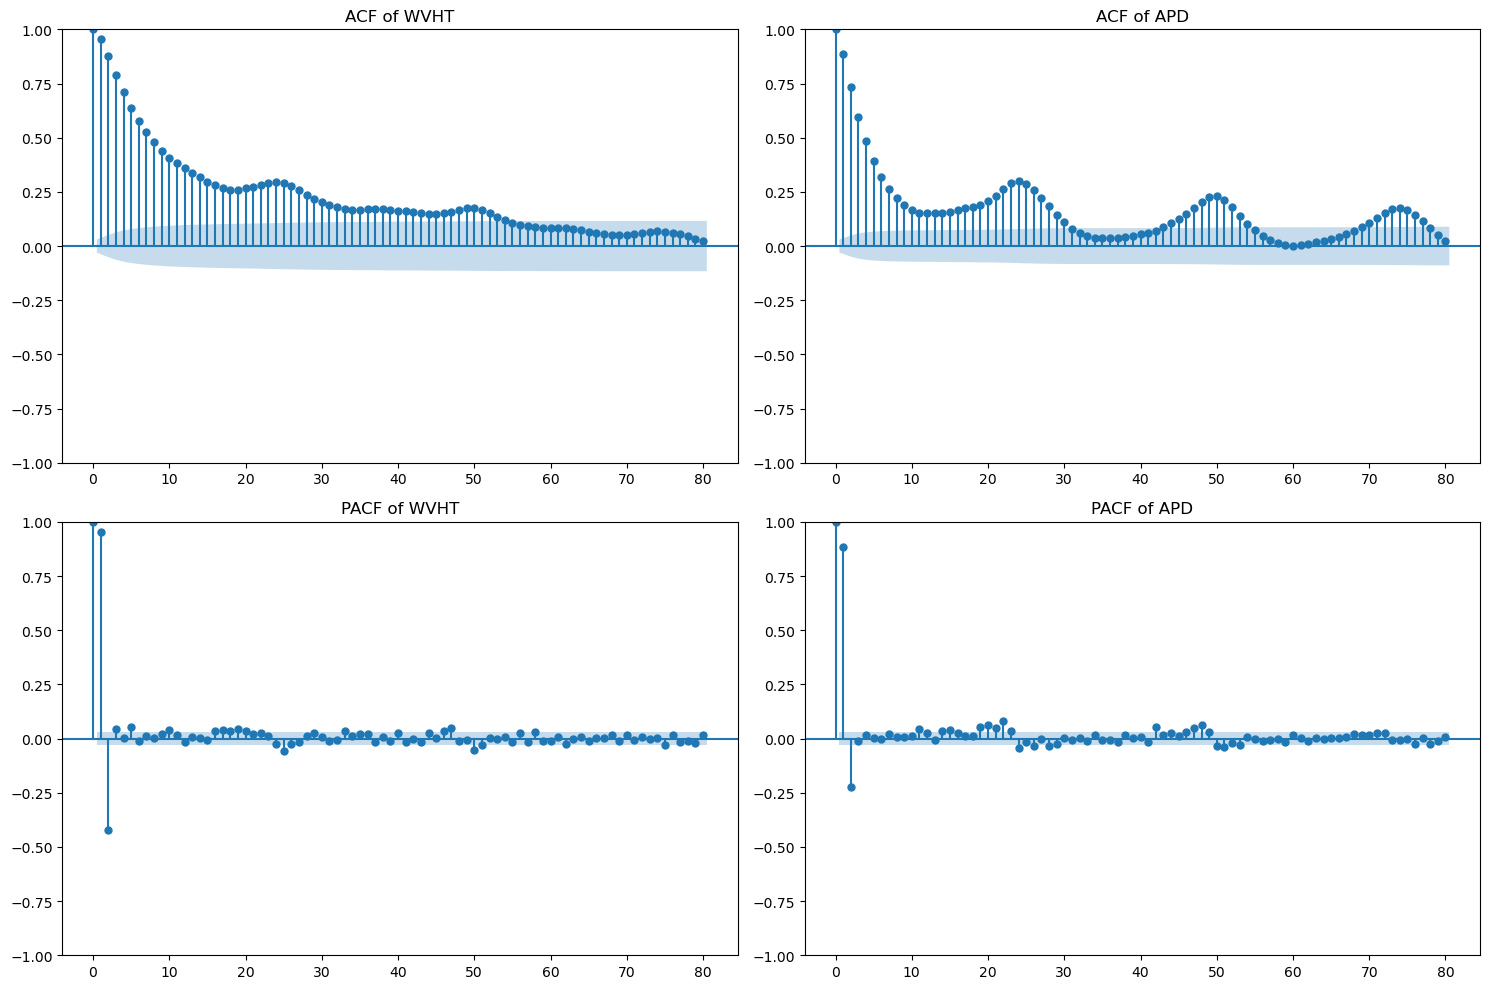

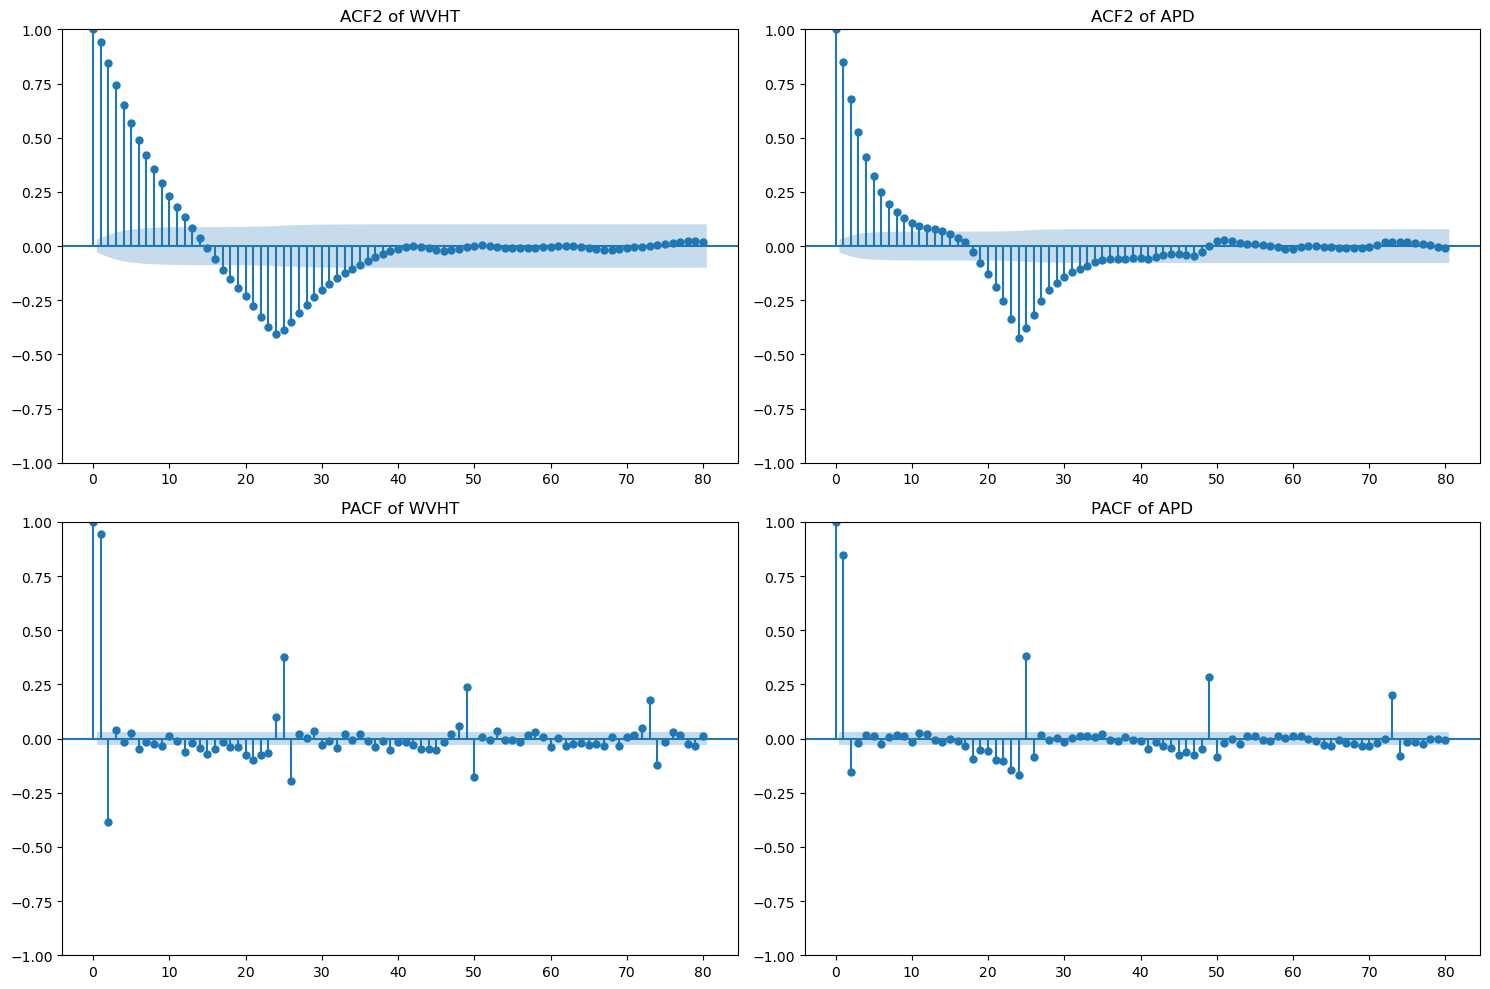

In [6]:
diff_lag = 24

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    plot_acf(Y_train_transformed[col], lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    plot_pacf(Y_train_transformed[col], lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

# Notes:
# We see a downward trend in ACF: A non-seasonal AR(1)
# We need peaks of 12, 24, 36, 48, 60, 72, 84: A seasonal MA(1) 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First row: ACF plots
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(diff_lag).dropna()
    plot_acf(series, lags=80, ax=axes[0, i])
    axes[0, i].set_title(f"ACF2 of {col}")

# Second row: PACF plots (imported here if not already available)
for i, col in enumerate(Y_train_transformed.columns):
    series =Y_train_transformed[col]
    series = series.diff(diff_lag).dropna()
    plot_pacf(series, lags=80, ax=axes[1, i])
    axes[1, i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()

In [ ]:


def setup_transformation_pipelines(X_train, y_train, diff_lag=24):
    """
    Create and fit all transformation pipelines in correct order.
    
    Returns:
        tuple: (pipe_X, pipe_Y, feat_pipeline, differencer, target_lag_summarizer)
    """
    
    # 1. Create target and feature scalers
    pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))
    
    # 2. Fit scalers on raw data
    X_train_scaled = pipe_X.fit_transform(X_train)
    y_train_scaled = pipe_Y.fit_transform(y_train)
    
    # 3. Create and fit differencer on scaled data
    differencer = Differencer(lags=[diff_lag], na_handling="fill_zero")
    differencer.fit(y_train_scaled)
    
    # 4. Create feature engineering pipeline
    def _add_calendar(df):
        df = df.copy()
        hr = df.index.hour
        df["month"] = df.index.month
        df["hour"] = hr
        df["hr_sin"] = np.sin(2 * np.pi * hr / 24)
        df["hr_cos"] = np.cos(2 * np.pi * hr / 24)
        return df
    
    calendar_tf = FunctionTransformer(_add_calendar, validate=False)
    
    exog_lag_tf = WindowSummarizer(
        lag_feature={
            "lag": [1],
            "mean": [[1, 24], [24, 48]],
        },
        target_cols=X_train.columns.tolist(), # Applying this only to X_train columns
        truncate="bfill",
    )
    
    feat_pipeline = Pipeline([
        ("calendar", calendar_tf),
        ("exog_lags", exog_lag_tf),
        ("scaler", StandardScaler()),
    ])
    
    # Fit feature pipeline on scaled training data
    feat_pipeline.fit(X_train_scaled)
    
    # 5. Create target lag summarizer
    target_lag_summarizer = WindowSummarizer(
        lag_feature={"lag": [1, 2, 3, 4, 24, 48, 72],
                     "mean": [[1, 24], [24, 48]],
    },
        
        truncate="bfill",
    )
    
    return pipe_X, pipe_Y, feat_pipeline, differencer, target_lag_summarizer

pipe_X, pipe_Y, feat_pipeline, differencer, target_lag_summarizer = setup_transformation_pipelines(X_train, y_train, diff_lag=24)
display(pipe_X)
display(pipe_Y)
display(feat_pipeline)
display(differencer)
display(target_lag_summarizer)

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


TransformerPipeline(steps=[('imputer',
                            ColumnEnsembleTransformer(remainder='passthrough',
                                                      transformers=[('arima_imp',
                                                                     Imputer(forecaster=AutoARIMA(max_p=3,
                                                                                                  max_q=3,
                                                                                                  n_jobs=-1,
                                                                                                  seasonal=False,
                                                                                                  start_p=1,
                                                                                                  start_q=0,
                                                                                                  suppress_warnings=True),
                                                                             method='forecaster'),
                                                                     ['MWD_sin']),
                                                                    ('ffill_imp',
                                                                     Imputer(method='ffill'),
                                                                     ['WSPD',
                                                                      'GST',
                                                                      'PRES',
                                                                      'ATMP',
                                                                      'WTMP',
                                                                      'DEWP',
                                                                      'WDIR_sin',
                                                                      'WDIR_cos',
                                                                      'MWD_cos'])])),
                           ('scaler',
                            ColumnEnsembleTransformer(remainder='passthrough',
                                                      transformers=[('scaler',
                                                                     TabularToSeriesAdaptor(transformer=StandardScaler()),
                                                                     ['WSPD',
                                                                      'GST',
                                                                      'PRES',
                                                                      'ATMP',
                                                                      'WTMP',
                                                                      'DEWP',
                                                                      'WDIR_sin',
                                                                      'WDIR_cos',
                                                                      'MWD_sin',
                                                                      'MWD_cos'])]))])

TransformerPipeline(steps=[('imputer', Imputer(method='ffill')),
                           ('scale',
                            TabularToSeriesAdaptor(transformer=StandardScaler()))])

Pipeline(steps=[('calendar',
                 FunctionTransformer(func=<function setup_transformation_pipelines.<locals>._add_calendar at 0x0000020B9D83D090>)),
                ('exog_lags',
                 WindowSummarizer(lag_feature={'lag': [1], 'mean': [[1, 24], [24, 48]]},
                 target_cols=['WSPD', 'GST', 'PRES', 'ATMP', 'WTMP', 'DEWP',
                              'WDIR_sin', 'WDIR_cos', 'MWD_sin', 'MWD_cos'],
                 truncate='bfill')),
                ('scaler', StandardScaler())])

Differencer(lags=[24])

WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4, 24, 48],
                              'mean': [[1, 24], [24, 48]]},
                 truncate='bfill')

# Evaluation metrics

In [ ]:
scorers = [MeanSquaredPercentageError(square_root=True), MeanAbsolutePercentageError()]

# Model Experiments

## XGBhoost

In [63]:
def run_xgboost_training():
    """Run XGBoost with data transformations."""
    
    
    # XGBoost configuration
    xgb_kwargs = {
        "n_estimators": 800,
        "learning_rate": 0.01,
        "max_depth": 8,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "tree_method": "hist",
        "objective": "reg:squarederror",
        "random_state": config.RANDOM_STATE,
        "n_jobs": -1,
    }
    
    regressor = XGBRegressor(**xgb_kwargs)
    forecaster = make_reduction(
        estimator=regressor,
        strategy="recursive", 
        transformers=[target_lag_summarizer],
        window_length=None,
        pooling="global",
    )
    
    return training.run_training_testing_pipeline(
        forecaster=forecaster,
        model_name="XGBoost",
        run_number=56,
        y_train=y_train,
        y_test=y_test,
        X_train=X_train,
        X_test=X_test,
        pipe_Y=pipe_Y,
        pipe_X=pipe_X,
        feat_pipeline=feat_pipeline,
        differencer=differencer,
        scorers=scorers,
        extra_params=xgb_kwargs,
        use_exog=True,
    )

### 5.1. Naive Forecaster

In [64]:

def run_naive_training():
    """Run Naive baseline with only scaling (no differencing)."""
    
    
    naive_forecasters = [
        ("naive_last_WVHT", NaiveForecaster(strategy="last"), ["WVHT"]),
        ("naive_mean_APD", NaiveForecaster(strategy="mean"), ["APD"]),
    ]
    
    forecaster = ColumnEnsembleForecaster(forecasters=naive_forecasters)
    
    return training.run_training_testing_pipeline(
        forecaster=forecaster,
        model_name="Naive",
        run_number=57,
        y_train=y_train,
        y_test=y_test,
        pipe_Y=pipe_Y,
        differencer=None,  # No differencing for naive baseline
        scorers=scorers,
        extra_params={"strategies": {"WVHT": "last", "APD": "mean"}},
        use_exog=False,
    )

### 5.2. SARIMA

In [65]:

def run_sarima_training():
    """Run SARIMA with data transformations."""
    
    sarima_forecasters = [
        ("SARIMA_WVHT", 
         ARIMA(order=(1, 0, 1), seasonal_order=(0, 0, 0, 24)), 
         ["WVHT"]),
        ("SARIMA_APD",
         ARIMA(order=(1, 0, 1), seasonal_order=(0, 0, 0, 24)),
         ["APD"]),
    ]
    
    forecaster = ColumnEnsembleForecaster(forecasters=sarima_forecasters)
    
    return training.run_training_testing_pipeline(
        forecaster=forecaster,
        model_name="SARIMA", 
        run_number=58,
        y_train=y_train,
        y_test=y_test,
        pipe_Y=pipe_Y,
        differencer=differencer,
        scorers=scorers,
        extra_params={"sarima_orders": "see_code"},
        use_exog=False,
    )

# Model Training

After benchmarking, we select the best model (or a model of interest) and perform a final evaluation on the hold-out test set.

In [66]:
# Run all models
xgb_run = run_xgboost_training()
naive_run = run_naive_training() 
sarima_run = run_sarima_training()


2025-07-20 23:42:04.075 | INFO     | oceanwave_forecast.mlflow_utils:_set_tracking_uri:55 - MLflow tracking URI set to: file:///D:%5CCML%5CTerm%208%5CML%20projects%5Cforecasting_workspace%5Coceanwave_forecast%5Cmlruns
2025-07-20 23:42:04.081 | INFO     | oceanwave_forecast.mlflow_utils:get_or_create_experiment:81 - Found existing experiment 'Oceanwave_Backtesting' with ID 197825032610997561.
2025-07-20 23:42:04.425 | INFO     | oceanwave_forecast.mlflow_utils:start_mlflow_run:134 - Started MLflow run with ID: ec7342d8d0cf48e5bb3262c6ef95311d
2025-07-20 23:42:04.451 | INFO     | oceanwave_forecast.mlflow_utils:log_params:159 - Logged parameters: dict_keys(['estimator', 'pooling', 'transformers', 'window_length', 'estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__callbacks', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__device', 'estimator__early_stopping_rounds', 'estimator__enable_categorical', 

🔄 Training XGBoost with horizon=72...


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
2025-07-20 23:43:03.091 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: n_blocks=3
2025-07-20 23:43:03.095 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: block_size=72


  Processing 3 blocks of size 72
  Block 1 MeanSquaredPercentageError: 0.6016
  Block 1 MeanAbsolutePercentageError: 0.4234
  Block 2 MeanSquaredPercentageError: 0.5507
  Block 2 MeanAbsolutePercentageError: 0.4266
  Block 3 MeanSquaredPercentageError: 0.6846
  Block 3 MeanAbsolutePercentageError: 0.5705

📊 Aggregated Scores:
  avg_MeanSquaredPercentageError: 0.6123
  std_MeanSquaredPercentageError: 0.0552
  avg_MeanAbsolutePercentageError: 0.4735
  std_MeanAbsolutePercentageError: 0.0686


2025-07-20 23:44:02.905 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run56_XGBoost_WVHT_blocks.png to plots
2025-07-20 23:44:03.329 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run56_XGBoost_APD_blocks.png to plots
2025-07-20 23:44:03.334 | INFO     | oceanwave_forecast.mlflow_utils:end_mlflow_run:147 - Ended MLflow run with ID: ec7342d8d0cf48e5bb3262c6ef95311d
2025-07-20 23:44:03.344 | INFO     | oceanwave_forecast.mlflow_utils:_set_tracking_uri:55 - MLflow tracking URI set to: file:///D:%5CCML%5CTerm%208%5CML%20projects%5Cforecasting_workspace%5Coceanwave_forecast%5Cmlruns
2025-07-20 23:44:03.350 | INFO     | oceanwave_forecast.mlflow_utils:get_or_create_experiment:81 - Found existing experiment 'Oceanwave_Backtesting' with ID 197825032610997561.


✅ XGBoost training complete (3 blocks processed)


2025-07-20 23:44:03.700 | INFO     | oceanwave_forecast.mlflow_utils:start_mlflow_run:134 - Started MLflow run with ID: c756ee13b1b9444fb3bce52d0a2cc148
2025-07-20 23:44:03.711 | INFO     | oceanwave_forecast.mlflow_utils:log_params:159 - Logged parameters: dict_keys(['forecasters', 'naive_last_WVHT', 'naive_mean_APD', 'naive_last_WVHT__sp', 'naive_last_WVHT__strategy', 'naive_last_WVHT__window_length', 'naive_mean_APD__sp', 'naive_mean_APD__strategy', 'naive_mean_APD__window_length'])
2025-07-20 23:44:03.716 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: model_type=Naive
2025-07-20 23:44:03.721 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: targets=WVHT,APD
2025-07-20 23:44:03.724 | INFO     | oceanwave_forecast.mlflow_utils:log_params:159 - Logged parameters: dict_keys(['strategies'])
2025-07-20 23:44:03.746 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: n_blocks=3
2025-07-20 23:44:03.751 

🔄 Training Naive with horizon=72...
  Processing 3 blocks of size 72
  Block 1 MeanSquaredPercentageError: 0.4946
  Block 1 MeanAbsolutePercentageError: 0.3495
  Block 2 MeanSquaredPercentageError: 0.7788
  Block 2 MeanAbsolutePercentageError: 0.5821
  Block 3 MeanSquaredPercentageError: 1.2558
  Block 3 MeanAbsolutePercentageError: 1.0903

📊 Aggregated Scores:
  avg_MeanSquaredPercentageError: 0.8431
  std_MeanSquaredPercentageError: 0.3141
  avg_MeanAbsolutePercentageError: 0.6740
  std_MeanAbsolutePercentageError: 0.3093


2025-07-20 23:44:04.345 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run57_Naive_WVHT_blocks.png to plots
2025-07-20 23:44:04.754 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run57_Naive_APD_blocks.png to plots
2025-07-20 23:44:04.758 | INFO     | oceanwave_forecast.mlflow_utils:end_mlflow_run:147 - Ended MLflow run with ID: c756ee13b1b9444fb3bce52d0a2cc148
2025-07-20 23:44:04.759 | INFO     | oceanwave_forecast.mlflow_utils:_set_tracking_uri:55 - MLflow tracking URI set to: file:///D:%5CCML%5CTerm%208%5CML%20projects%5Cforecasting_workspace%5Coceanwave_forecast%5Cmlruns
2025-07-20 23:44:04.766 | INFO     | oceanwave_forecast.mlflow_utils:get_or_create_experiment:81 - Found existing experiment 'Oceanwave_Backtesting' with ID 197825032610997561.


✅ Naive training complete (3 blocks processed)


2025-07-20 23:44:05.100 | INFO     | oceanwave_forecast.mlflow_utils:start_mlflow_run:134 - Started MLflow run with ID: b9309e53819a401391166795bf4e7041
2025-07-20 23:44:05.123 | INFO     | oceanwave_forecast.mlflow_utils:log_params:159 - Logged parameters: dict_keys(['forecasters', 'SARIMA_WVHT', 'SARIMA_APD', 'SARIMA_WVHT__concentrate_scale', 'SARIMA_WVHT__enforce_invertibility', 'SARIMA_WVHT__enforce_stationarity', 'SARIMA_WVHT__hamilton_representation', 'SARIMA_WVHT__maxiter', 'SARIMA_WVHT__measurement_error', 'SARIMA_WVHT__method', 'SARIMA_WVHT__mle_regression', 'SARIMA_WVHT__order', 'SARIMA_WVHT__out_of_sample_size', 'SARIMA_WVHT__scoring', 'SARIMA_WVHT__scoring_args', 'SARIMA_WVHT__seasonal_order', 'SARIMA_WVHT__simple_differencing', 'SARIMA_WVHT__start_params', 'SARIMA_WVHT__suppress_warnings', 'SARIMA_WVHT__time_varying_regression', 'SARIMA_WVHT__trend', 'SARIMA_WVHT__with_intercept', 'SARIMA_APD__concentrate_scale', 'SARIMA_APD__enforce_invertibility', 'SARIMA_APD__enforce_st

🔄 Training SARIMA with horizon=72...


2025-07-20 23:44:06.194 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: n_blocks=3
2025-07-20 23:44:06.199 | INFO     | oceanwave_forecast.mlflow_utils:log_param:170 - Logged parameter: block_size=72


  Processing 3 blocks of size 72
  Block 1 MeanSquaredPercentageError: 0.4293
  Block 1 MeanAbsolutePercentageError: 0.3276
  Block 2 MeanSquaredPercentageError: 0.5612
  Block 2 MeanAbsolutePercentageError: 0.4012
  Block 3 MeanSquaredPercentageError: 0.9144
  Block 3 MeanAbsolutePercentageError: 0.7837

📊 Aggregated Scores:
  avg_MeanSquaredPercentageError: 0.6349
  std_MeanSquaredPercentageError: 0.2048
  avg_MeanAbsolutePercentageError: 0.5042
  std_MeanAbsolutePercentageError: 0.2000


2025-07-20 23:44:06.984 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run58_SARIMA_WVHT_blocks.png to plots
2025-07-20 23:44:07.382 | INFO     | oceanwave_forecast.mlflow_utils:log_artifact:205 - Logged artifact: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\reports\Run58_SARIMA_APD_blocks.png to plots
2025-07-20 23:44:07.386 | INFO     | oceanwave_forecast.mlflow_utils:end_mlflow_run:147 - Ended MLflow run with ID: b9309e53819a401391166795bf4e7041


✅ SARIMA training complete (3 blocks processed)


# Inferece

In [67]:

def monitor_experiments():
    """
    Monitor and display all forecasting project experiments.
    """
    TAG_KEY, TAG_VALUE = "project", "forecasting"
    
    experiments = mlflow_utils.MLflowExperimentManager.search_experiments_by_tag(TAG_KEY, TAG_VALUE)
    
    print(f"📊 Found {len(experiments)} experiments with tag {TAG_KEY}={TAG_VALUE}")
    
    for exp in experiments:
        print(f"\n=== Experiment: {exp.name} (id={exp.experiment_id}) ===")
        mlflow_utils.MLflowExperimentManager.print_experiment_runs_tree(exp.experiment_id)

def analyze_run_details(client, run, run_id):
    """
    Analyze and display run details including parameters, metrics, and artifacts.
    Enhanced to handle block-wise metrics structure.
    """
    print("\n" + "="*50)
    print("📊 RUN ANALYSIS")
    print("="*50)
    
    print("\n=== Parameters ===")
    params_df = pd.Series(run.data.params)
    print(params_df.to_string())
    
    print("\n=== Tags ===")
    tags_df = pd.Series(run.data.tags)
    print(tags_df.to_string())
    
    print("\n=== Metrics ===")
    metrics = run.data.metrics
    
    # Separate aggregated and block metrics
    agg_metrics = {k: v for k, v in metrics.items() if k.startswith(('avg_', 'std_'))}
    block_metrics = {k: v for k, v in metrics.items() if k.startswith('block_')}
    other_metrics = {k: v for k, v in metrics.items() if not k.startswith(('avg_', 'std_', 'block_'))}
    
    if agg_metrics:
        print("\n🎯 Aggregated Performance:")
        for metric, value in agg_metrics.items():
            print(f"  {metric} → {value:.4f}")
    
    if block_metrics:
        print(f"\n📊 Block-wise Performance ({len([k for k in block_metrics if 'block_1_' in k])} blocks):")
        for metric, value in block_metrics.items():
            print(f"  {metric} → {value:.4f}")
    
    if other_metrics:
        print("\n📈 Other Metrics:")
        for metric, value in other_metrics.items():
            print(f"  {metric} → {value:.4f}")
    
    print("\n=== Artifacts ===")
    artifacts = client.list_artifacts(run_id)
    for artifact in artifacts:
        print(f"  📁 {artifact.path}")

def compare_model_performance():
    """
    Compare performance across all model runs with block-wise metrics.
    """
    experiment_name = config.MLFLOW_CONFIG_BACKTESTING['experiment_name']
    
    model_results = {}
    for run_number, model_name in [(1, "XGBoost"), (2, "Naive"), (3, "SARIMA")]:
        run = mlflow_utils.MLflowExperimentManager.get_run_details(experiment_name, run_number)
        if run:
            model_results[model_name] = run.data.metrics
            # Add block info
            params = run.data.params
            model_results[model_name]['_n_blocks'] = params.get('n_blocks', 'N/A')
            model_results[model_name]['_block_size'] = params.get('block_size', 'N/A')
    
    print("\n=== Model Performance Comparison ===")
    for model_name, metrics in model_results.items():
        print(f"\n{model_name} Results:")
        print(f"  Blocks: {metrics.get('_n_blocks')} × {metrics.get('_block_size')}")
        
        # Show aggregated metrics first
        agg_metrics = {k: v for k, v in metrics.items() if k.startswith(('avg_', 'std_'))}
        if agg_metrics:
            print("  Aggregated Performance:")
            for metric_name, value in agg_metrics.items():
                print(f"    {metric_name} → {value:.4f}")
        
        # Show other metrics
        other_metrics = {k: v for k, v in metrics.items() if not k.startswith(('avg_', 'std_', 'block_', '_'))}
        if other_metrics:
            print("  Other Metrics:")
            for metric_name, value in other_metrics.items():
                print(f"    {metric_name} → {value:.4f}")

In [68]:
# Monitor experiments
from mlflow.tracking import MlflowClient
monitor_experiments()

# Compare model performance
compare_model_performance()

# Analyze individual runs if needed
experiment_name = config.MLFLOW_CONFIG_BACKTESTING['experiment_name']
client = MlflowClient()

for run_number, model_name in [(14, "XGBoost"), (15, "Naive"), (16, "SARIMA")]:
    run = mlflow_utils.MLflowExperimentManager.get_run_details(experiment_name, run_number)
    if run:
        print(f"\n{'='*60}")
        print(f"DETAILED ANALYSIS: {model_name}")
        print('='*60)
        analyze_run_details(client, run, run.info.run_id)

2025-07-20 23:44:23.991 | INFO     | oceanwave_forecast.mlflow_utils:search_experiments_by_tag:295 - Found 0 experiments with tag 'project'='forecasting'.


📊 Found 0 experiments with tag project=forecasting


2025-07-20 23:44:24.316 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run ba88baab4d7b4624a82a29b3b987d5bf for experiment 'Oceanwave_Backtesting' and run_number 1.
2025-07-20 23:44:24.633 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run d159f7b2ca184bfead9a53ea92e68ccf for experiment 'Oceanwave_Backtesting' and run_number 2.
2025-07-20 23:44:24.943 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run 7d774d30df684c0d9dfdc10851f7cfeb for experiment 'Oceanwave_Backtesting' and run_number 3.



=== Model Performance Comparison ===

XGBoost Results:
  Blocks: N/A × N/A
  Other Metrics:
    MeanAbsolutePercentageError → 0.2534
    MeanSquaredPercentageError → 0.3401

Naive Results:
  Blocks: N/A × N/A
  Other Metrics:
    MeanAbsolutePercentageError → 0.4605
    MeanSquaredPercentageError → 0.6236

SARIMA Results:
  Blocks: N/A × N/A
  Other Metrics:
    MeanAbsolutePercentageError → 2.3095
    MeanSquaredPercentageError → 3.0938


2025-07-20 23:44:25.257 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run 895290c2b0624cc7bbaa9fc8d7d91168 for experiment 'Oceanwave_Backtesting' and run_number 14.



DETAILED ANALYSIS: XGBoost

📊 RUN ANALYSIS

=== Parameters ===
colsample_bytree                                                                    0.8
device                                                                             cuda
estimator                             XGBRegressor(base_score=None, booster=None, ca...
estimator__base_score                                                              None
estimator__booster                                                                 None
estimator__callbacks                                                               None
estimator__colsample_bylevel                                                       None
estimator__colsample_bynode                                                        None
estimator__colsample_bytree                                                         0.8
estimator__device                                                                  cuda
estimator__early_stopping_rounds                        

2025-07-20 23:44:25.605 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run 925dd98b78284e20b61410fa504f58b6 for experiment 'Oceanwave_Backtesting' and run_number 15.



DETAILED ANALYSIS: Naive

📊 RUN ANALYSIS

=== Parameters ===
forecasters                       [('naive_last_WVHT', NaiveForecaster(), ['WVHT...
model_type                                                                    Naive
naive_last_WVHT                                                   NaiveForecaster()
naive_last_WVHT__sp                                                               1
naive_last_WVHT__strategy                                                      last
naive_last_WVHT__window_length                                                 None
naive_mean_APD                                     NaiveForecaster(strategy='mean')
naive_mean_APD__sp                                                                1
naive_mean_APD__strategy                                                       mean
naive_mean_APD__window_length                                                  None
run_number                                                                       15
strategies    

2025-07-20 23:44:25.949 | INFO     | oceanwave_forecast.mlflow_utils:get_run_details:253 - Found run d586181f8db949658b23b4d7f4fffb79 for experiment 'Oceanwave_Backtesting' and run_number 16.



DETAILED ANALYSIS: SARIMA

📊 RUN ANALYSIS

=== Parameters ===
forecasters                             [('SARIMA_WVHT', ARIMA(order=(1, 0, 1), season...
model_type                                                                         SARIMA
run_number                                                                             16
SARIMA_APD                              ARIMA(order=(1, 0, 1), seasonal_order=(0, 0, 0...
SARIMA_APD__concentrate_scale                                                       False
SARIMA_APD__enforce_invertibility                                                    True
SARIMA_APD__enforce_stationarity                                                     True
SARIMA_APD__hamilton_representation                                                 False
SARIMA_APD__maxiter                                                                    50
SARIMA_APD__measurement_error                                                       False
SARIMA_APD__method                   